In [1]:
#!pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset

/home/sanjaymoto75/.conda/envs/env/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [70]:
from efficientnet_pytorch import EfficientNet
from ConvLSTM_pytorch.convlstm import ConvLSTM
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        model = models.vgg16_bn(pretrained = True)
        model = nn.Sequential(*[model.features[i] for i in range(43)])
        self.model = model
        self.c1 = ConvLSTM(  input_size=(7,7),
                             input_dim=512,
                             hidden_dim=[64, 128],
                             kernel_size=(5,5),
                             num_layers=2,
                             batch_first = True,
                             bias=True,
                             return_all_layers = False)
        self.fc1 = nn.Linear(6272,1000)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(1000)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(10)
        self.fc2 = nn.Linear(1000,256)
        self.fc3 = nn.Linear(256,4)
        self.dp = nn.Dropout(0.1)
    def forward(self, x):
        x = self.model(x)
        x = x.view(-1,150,512,7,7).detach()
        x = self.c1(x)
        x = x[0][0][:,-1,:,:,:]
        x = x.view(-1,6272)
        x = self.dp(self.relu(self.fc1(x)))
        x = self.dp(self.relu(self.fc2(x)))
        x = self.dp(self.fc3(x))
        return x
model = Model().to('cuda')
model = nn.DataParallel(model)

In [66]:
import numpy as np
x = model(torch.from_numpy(np.empty((240,3,112,112))).type(torch.cuda.FloatTensor))

In [2]:
def frame_extract(path):
    vidObj = cv2.VideoCapture(path) 
    success = 1
    while success:
        success, image = vidObj.read()
        if success:
            yield image

In [3]:
import pandas as pd
train_label = pd.read_csv('./DAiSEE/Labels/TrainLabels.csv')
valid_label = pd.read_csv('./DAiSEE/Labels/ValidationLabels.csv')
test_label = pd.read_csv('./DAiSEE/Labels/TestLabels.csv')

In [26]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
from tqdm.autonotebook import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys
im_size = 112

In [27]:
class video_dataset(Dataset):
    def __init__(self,frame_dir,id,label,sequence_length = 60,transform = None):
        self.folder = os.listdir(frame_dir)
        self.id =id
        self.engagement = label
        self.frame_dir = frame_dir
        self.transform = transform
        self.count = 0
    def __len__(self):
        return len(self.id)-self.count
    def __getitem__(self,idx):
        video_path = self.id[idx]
        frames = []
        for frame in frame_extract(video_path):
            frames.append(self.transform(frame))
        frames = torch.stack(frames)
        if(len(frames)<150):
            print(video_path)
            os.remove(video_path)
        if(len(frames)>=300):
            frames = frames[::2,:,:,:]
            frames = frames[:150]
        else:
            frames = frames[:150]
        frames = frames.reshape(150,3,im_size,im_size)
        #frames = frames.permute(1,0,2,3)
        label = self.engagement[idx]
        return frames,label

In [7]:
id_1 = train_label['ClipID']
label = train_label['Engagement']
id_train = []
label_train = []
for id in range(len(id_1)):
    path1 = os.path.join('./DataSet/Train',id_1[id][:6])
    id_2 = id_1[id][:-4]
    video_path = os.path.join(path1,id_2)
    if(os.path.exists(video_path)):
        if(os.path.exists(os.path.join(video_path,os.listdir(video_path)[0]))):
            id_train.append(os.path.join(video_path,os.listdir(video_path)[0]))
            label_train.append(label[id])

In [8]:
id_1 = valid_label['ClipID']
label = valid_label['Engagement']
id_val = []
label_val = []
for id in range(len(id_1)):
    path1 = os.path.join('./DataSet/Validation',id_1[id][:6])
    id_2 = id_1[id][:-4]
    video_path = os.path.join(path1,id_2)
    if(os.path.exists(video_path)):
        try:
            if(os.path.exists(os.path.join(video_path,os.listdir(video_path)[0]))):
                id_val.append(os.path.join(video_path,os.listdir(video_path)[0]))
                label_val.append(label[id])
        except:
            pass

In [9]:
id_1 = test_label['ClipID']
label = test_label['Engagement']
id_test = []
label_test = []
for id in range(len(id_1)):
    path1 = os.path.join('./DataSet/Test',id_1[id][:6])
    id_2 = id_1[id][:-4]
    video_path = os.path.join(path1,id_2)
    if(os.path.exists(video_path)):
        try:
            if(os.path.exists(os.path.join(video_path,os.listdir(video_path)[0]))):
                id_test.append(os.path.join(video_path,os.listdir(video_path)[0]))
                label_test.append(label[id])
        except:
            pass

In [10]:
id_val = id_val + id_test
label_val = label_val + label_test

In [11]:
mean = [0.43216, 0.394666, 0.37645]
std = [0.22803, 0.22145, 0.216989]

In [28]:
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset('./DataSet/Train',id_train,label_train,sequence_length = 100,transform = train_transforms)
val_data = video_dataset('./DataSet/Validation',id_val,label_val,sequence_length = 100,transform = train_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


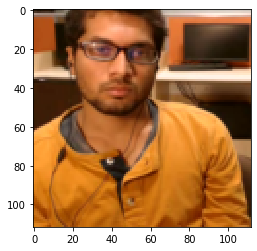

In [13]:
import cv2
import random
image,_ = train_data[3900]
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()
im_plot(image[10,:,:,:])

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

__all__ = ['resnet50', 'resnet101','resnet152', 'resnet200']



class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, head_conv=1):
        super(Bottleneck, self).__init__()
        if head_conv == 1:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm3d(planes)
        elif head_conv == 3:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), bias=False, padding=(1, 0, 0))
            self.bn1 = nn.BatchNorm3d(planes)
        else:
            raise ValueError("Unsupported head_conv!")
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=(1, 3, 3), stride=(1,stride,stride), padding=(0, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out


class SlowFast(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], class_num=10, dropout=0.2):
        super(SlowFast, self).__init__()

        self.fast_inplanes = 8
        self.fast_conv1 = nn.Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
        self.fast_bn1 = nn.BatchNorm3d(8)
        self.fast_relu = nn.ReLU(inplace=True)
        self.fast_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.fast_res2 = self._make_layer_fast(block, 8, layers[0], head_conv=3)
        self.fast_res3 = self._make_layer_fast(
            block, 16, layers[1], stride=2, head_conv=3)
        self.fast_res4 = self._make_layer_fast(
            block, 32, layers[2], stride=2, head_conv=3)
        self.fast_res5 = self._make_layer_fast(
            block, 64, layers[3], stride=2, head_conv=3)
        self.lateral_p1 = nn.Conv3d(8, 8*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res2 = nn.Conv3d(32,32*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res3 = nn.Conv3d(64,64*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res4 = nn.Conv3d(128,128*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))

        self.slow_inplanes = 64+64//8*2
        self.slow_conv1 = nn.Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        self.slow_bn1 = nn.BatchNorm3d(64)
        self.slow_relu = nn.ReLU(inplace=True)
        self.slow_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.slow_res2 = self._make_layer_slow(block, 64, layers[0], head_conv=1)
        self.slow_res3 = self._make_layer_slow(
            block, 128, layers[1], stride=2, head_conv=1)
        self.slow_res4 = self._make_layer_slow(
            block, 256, layers[2], stride=2, head_conv=3)
        self.slow_res5 = self._make_layer_slow(
            block, 512, layers[3], stride=2, head_conv=3)
        self.dp = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 2, bias=False)
    def forward(self, input):
        lateral = []
        x = self.fast_conv1(input)
        x = self.fast_bn1(x)
        x = self.fast_relu(x)
        pool1 = self.fast_maxpool(x)
        res2 = self.fast_res2(pool1)
        
        res3 = self.fast_res3(res2)

        res4 = self.fast_res4(res3)

        res5 = self.fast_res5(res4)
        x = nn.AdaptiveAvgPool3d(1)(res5)
        x = x.view(-1, x.size(1))
        
        return x

    def _make_layer_fast(self, block, planes, blocks, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.fast_inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.fast_inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=(1,stride,stride),
                    bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.fast_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.fast_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.fast_inplanes, planes, head_conv=head_conv))
        return nn.Sequential(*layers)

    def _make_layer_slow(self, block, planes, blocks, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.slow_inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.slow_inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=(1,stride,stride),
                    bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.slow_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.slow_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.slow_inplanes, planes, head_conv=head_conv))
  
        self.slow_inplanes = planes * block.expansion + planes * block.expansion//8*2
        return nn.Sequential(*layers)




def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

In [40]:
from torchvision import models
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        model = models.vgg16_bn(pretrained = True)
        model.classifier = model.classifier[:5]
        for param in model.parameters():
            param.requires_grad = False
        self.model = model
        self.lstm = nn.LSTM(4096,1024,2,batch_first=True ,dropout = 0.4)
        self.l1 = nn.Linear(1024+256,256)
        self.dp = nn.Dropout(0.4)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(256,4)
        self.fast = resnet50()
    def forward(self,x):
        self.lstm.flatten_parameters()
        out = self.model(x)
        f = self.fast(x.reshape(-1,3,150,112,112).detach())    
        out1 = out.view(-1,150,4096).detach()
        out,_ = self.lstm(out1,None)
        out = torch.mean(out,dim=1)
        out = torch.cat([out,f],dim = 1)
        out = self.relu(self.l1(out))
        out = self.dp(out)
        out = self.l2(out)
        return out

In [41]:
model = Model().to('cuda')
model(torch.from_numpy(np.empty((600,3,112,112))).type(torch.cuda.FloatTensor))
#model.load_state_dict(torch.load('./weights_att1/lstm-b1.h5')['dict'])

tensor([[-0.0617, -0.0258, -0.0344,  0.0015],
        [-0.0495, -0.0260, -0.0333, -0.0107],
        [-0.0410, -0.0414, -0.0347, -0.0283],
        [-0.0476, -0.0299, -0.0190, -0.0063]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [42]:
model = nn.DataParallel(model)

In [14]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [15]:
from Modular_code.lr_finder import *
from RAdam.radam import RAdam

In [16]:
def lr_finder(model,train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = RAdam(model.parameters(), lr=1e-6)
    lr_finder = LRFinder(model, optimizer_ft, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=1, num_iter=1000)
    lr_finder.reset()
    lr_finder.plot()

In [17]:
os.makedirs('./weights_att1',exist_ok = True)
import sys
import cv2
import torch.optim as optim
from torch.autograd import Variable
device = 'cuda'
criterion = nn.CrossEntropyLoss().to(device)
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

def train(model,dataloaders,num_epochs,lr):
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc_all = list()
    train_loader = dataloaders['train']
    iteration = 0
    iteration1 = 0
    onecyc = OneCycle(len(train_loader)*num_epochs,lr)
    optimizer = RAdam(model.parameters(), lr=lr ,weight_decay = 1e-3)
    for epoch in range(num_epochs):
        print('------------------Epoch: {} ------------------'.format(epoch))
        if(epoch%10==0 and epoch!=0):
            lr = 0.9*lr
            num_epochs = num_epochs-10
            onecyc = OneCycle(len(train_loader)*num_epochs,lr)
            optimizer = RAdam(model.parameters(), lr=lr ,weight_decay = 1e-3)
        
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            if(phase  == 'train'):
                model = model.train()
                print('')
                print('-------------------{}------------------'.format(phase))
            
            else:
                model = model.eval()
                print('')
                print('-------------------{}------------------'.format(phase))
            it = iter(dataloaders[phase])
            for  batch_idx in range(len(it)):
                data,target = next(it)
                if(data.size(0)<8):
                    continue
                with torch.no_grad():
                    data = data.reshape(-1,3,im_size,im_size)
                data, target = Variable(data), Variable(target)
                data = data.type(torch.FloatTensor).to(device)
                target = target.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                output = model(data)
                del data
                loss = criterion(output, target)
                if(phase =='train'):
                    loss.cuda().backward()
                    optimizer.step()
                    lr,_ = onecyc.calc()
                    update_lr(optimizer, lr)
                acc = 100 * (output.detach().argmax(1) == target).cpu().numpy().mean()
                epoch_metrics["loss"].append(loss.detach().item())
                epoch_metrics["acc"].append(acc)
                del output,target

                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                    #, Acc: %.2f%% (%.2f%%)
                % (
                    epoch,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                    )
                )
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                del loss
            epoch_acc = np.mean(epoch_metrics["acc"])
            epoch_loss = np.mean(epoch_metrics["loss"])
            if(phase == 'train'):
                losses.append(epoch_loss)
                acc_all.append(epoch_acc)
                save = {
                    'model':'convlstmdense',
                    'epoch':epoch,
                    'train_loss':epoch_loss,
                    'train_acc':epoch_acc,
                    'dict':model.module.state_dict(),
                    'lr':lr
                }
                torch.save(save,'./weights_att1/convlstmvggdense.h5')
            print('')
            print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
    return losses,acc_all

In [32]:
#!git clone https://github.com/ndrplz/ConvLSTM_pytorch
from ConvLSTM_pytorch.convlstm import ConvLSTM
size = 3
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        model = models.densenet121(pretrained = True).to('cuda')
        modules= list(model.children())[0]
        model = nn.Sequential(*modules)
        self.model = model
        self.c1 = ConvLSTM(  input_size=(size,size),
                             input_dim= 1024,
                             hidden_dim=[128, 512],
                             kernel_size=(5,5),
                             num_layers=2,
                             batch_first = True,
                             bias=True,
                             return_all_layers=False)
        self.fc1 = nn.Linear(512*size*size,1000)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(1000)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(10)
        self.fc2 = nn.Linear(1000,256)
        self.fc3 = nn.Linear(256,4)
        self.dp = nn.Dropout(0.2)
    def forward(self, x):
        x = self.model(x)
        x = x.view(-1,150,1024,size,size).detach()
        x = self.c1(x)
        x = x[0][0][:,-1,:,:,:]
        x = x.view(-1,512*size*size)
        x = self.dp(self.relu(self.fc1(x)))
        x = self.dp(self.relu(self.fc2(x)))
        x = self.dp(self.fc3(x))
        return x
model = Model().to('cuda')
model = nn.DataParallel(model)

In [30]:
model(torch.from_numpy(np.empty((600,3,112,112))).type(torch.cuda.FloatTensor))

tensor([[ 0.0270, -0.0849,  0.0733, -0.0081],
        [ 0.0000, -0.0735,  0.0671,  0.0000],
        [ 0.0405,  0.0000,  0.0000, -0.0016],
        [ 0.0317, -0.0802,  0.0000, -0.0141]], device='cuda:0',
       grad_fn=<GatherBackward>)

In [ ]:
from Modular_code.clr import OneCycle
train_loader -= DataLoader(train_data,batch_size = 8,num_workers = 8,shuffle = True) 
valid_loader = DataLoader(val_data,batch_size = 8,num_workers = 8)
dataloaders = {'train':train_loader,'val':valid_loader}
train(model,dataloaders,10,0.001)

------------------Epoch: 0 ------------------

-------------------train------------------
[Epoch 0/10] [Batch 668/670] [Loss: 1.286654 (0.939132), Acc: 62.50% (52.39%)]]
train Accuracy: 52.39162929745889

-------------------val------------------
[Epoch 0/10] [Batch 377/379] [Loss: 0.911518 (0.935621), Acc: 75.00% (52.73%)]]
val Accuracy: 52.734001910219675
------------------Epoch: 1 ------------------

-------------------train------------------
[Epoch 1/10] [Batch 668/670] [Loss: 0.728169 (0.929984), Acc: 37.50% (54.41%)]]
train Accuracy: 54.40956651718984

-------------------val------------------
[Epoch 1/10] [Batch 377/379] [Loss: 1.070114 (0.932478), Acc: 25.00% (54.37%)]]
val Accuracy: 54.36962750716332
------------------Epoch: 2 ------------------

-------------------train------------------
[Epoch 2/10] [Batch 668/670] [Loss: 0.937133 (0.939001), Acc: 62.50% (54.07%)]]
train Accuracy: 54.073243647234676

-------------------val------------------
[Epoch 2/10] [Batch 377/379] [Loss: 

In [ ]:
for i,param in enumerate(model.module.model.parameters()):
    param.requires_grad = True

In [ ]:
from Modular_code.clr import OneCycle
train_loader = DataLoader(train_data,batch_size = 4,num_workers = 12,shuffle = True)
valid_loader = DataLoader(val_data,batch_size = 4,num_workers = 12)
dataloaders = {'train':train_loader,'val':valid_loader}
train(model,dataloaders,10,0.005)

In [ ]:
for param in model.module.model.parameters():
    param.requires_grad = True

In [ ]:
test_data = video_dataset('./DataSet/Validation',valid_label,sequence_length = 100,transform = test_transforms)
test_loader = DataLoader(test_data,batch_size = 8,num_workers = 8)

In [ ]:
criterion = nn.CrossEntropyLoss()
model = model.train()
epoch_metrics = {"loss": [], "acc": []}        
for data,target in tqdm(test_loader):
    data, target = Variable(data), Variable(target)
    data = data.type(torch.FloatTensor).to(device)
    target = target.type(torch.LongTensor).to(device)
    data = data.reshape(-1,3,im_size,im_size)
    output = model(data)
    loss = criterion(output, target)
    acc = 100 * (output.detach().argmax(1) == target).cpu().numpy().mean()
    epoch_metrics["loss"].append(loss.item())
    epoch_metrics["acc"].append(acc)
    del loss,data,output,target
    torch.cuda.empty_cache()
epoch_acc = np.mean(epoch_metrics["acc"])
epoch_loss = np.mean(epoch_metrics["loss"])    

In [ ]:
epoch_metrics['acc']

In [ ]:
print(epoch_acc,epoch_loss)

In [ ]:
#regression
os.makedirs('./weights_att1',exist_ok = True)
import sys
import cv2
from torch.autograd import Variable
device = 'cuda'
criterion = nn.MSELoss().to(device)
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

def train(model,dataloaders,device,num_epochs,lr,batch_size,patience):
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc_all = list()
    train_loader = dataloaders['train']
    iteration = 0
    iteration1 = 0
    onecyc = OneCycle(len(train_loader)*num_epochs,lr)
    optimizer = RAdam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        print('------------------Epoch: {} ------------------'.format(epoch))
        if(epoch%20==0 and epoch!=0):
            lr = 0.9*lr
            num_epochs = num_epochs-20
            onecyc = OneCycle(len(train_loader)*num_epochs,lr)
            optimizer = RAdam(model.parameters(), lr=lr)
        
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            print('')
            print('-------------------{}------------------'.format(phase))
            if(phase  == 'train'):
                model = model.train()
            else:
                model = model.eval()
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                bs = data.size(0)
                data, target = Variable(data), Variable(target)
                data = data.type(torch.FloatTensor).to(device)
                target = target.type(torch.FloatTensor).to(device)
                optimizer.zero_grad()
                output = model(data)
                del data
                loss = criterion(output.squeeze(), target)
                #acc = 100 * (output.detach().argmax(1) == target).cpu().numpy().mean()
                del output,target
                epoch_metrics["loss"].append(loss.item())
                #epoch_metrics["acc"].append(acc)
                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
                    #, Acc: %.2f%% (%.2f%%)
                % (
                    epoch,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    loss.item(),
                    np.mean(epoch_metrics["loss"])#,
                    #acc,
                   # np.mean(epoch_metrics["acc"]),
                    )
                )

                if(phase =='train'):
                    loss.backward()
                    optimizer.step()
                    lr,_ = onecyc.calc()
                    update_lr(optimizer, lr)
                    iteration = iteration+1
                    #writer.add_scalar('data/acc',np.mean(epoch_metrics["acc"]) , iteration)
                    writer.add_scalar('data/loss',np.mean(epoch_metrics["loss"]) , iteration)
                if(phase=='val'):
                    iteration1 = iteration1+1
                    #writer.add_scalar('data/valacc',np.mean(epoch_metrics["acc"]) , iteration1)
                    writer.add_scalar('data/valloss',np.mean(epoch_metrics["loss"]) , iteration1)
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
         #   epoch_acc = np.mean(epoch_metrics["acc"])
            epoch_loss = np.mean(epoch_metrics["loss"])
            if(phase == 'train'):
                losses.append(epoch_loss)
                #acc_all.append(epoch_acc)
                #writer.add_scalar('data/accep',np.mean(epoch_metrics["acc"]) , epoch)
                writer.add_scalar('data/lossep',np.mean(epoch_metrics["loss"]) , epoch)
                save = {
                    'model':'101-b0',
                    'epoch':epoch,
                    'train_loss':epoch_loss,
                    #'train_acc':epoch_acc,
                    'dict':model.module.state_dict(),
                    'lr':lr
                }
                torch.save(save,'./weights_att1/slow_fast101-b0-1.h5')
            print('')
          #  print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
    return losses,acc_all

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

__all__ = ['resnet50', 'resnet101','resnet152', 'resnet200']



class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, head_conv=1):
        super(Bottleneck, self).__init__()
        if head_conv == 1:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm3d(planes)
        elif head_conv == 3:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), bias=False, padding=(1, 0, 0))
            self.bn1 = nn.BatchNorm3d(planes)
        else:
            raise ValueError("Unsupported head_conv!")
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=(1, 3, 3), stride=(1,stride,stride), padding=(0, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out


class SlowFast(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], class_num=10, dropout=0.2):
        super(SlowFast, self).__init__()

        self.fast_inplanes = 8
        self.fast_conv1 = nn.Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
        self.fast_bn1 = nn.BatchNorm3d(8)
        self.fast_relu = nn.ReLU(inplace=True)
        self.fast_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.fast_res2 = self._make_layer_fast(block, 8, layers[0], head_conv=3)
        self.fast_res3 = self._make_layer_fast(
            block, 16, layers[1], stride=2, head_conv=3)
        self.fast_res4 = self._make_layer_fast(
            block, 32, layers[2], stride=2, head_conv=3)
        self.fast_res5 = self._make_layer_fast(
            block, 64, layers[3], stride=2, head_conv=3)
        
        self.lateral_p1 = nn.Conv3d(8, 8*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res2 = nn.Conv3d(32,32*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res3 = nn.Conv3d(64,64*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))
        self.lateral_res4 = nn.Conv3d(128,128*2, kernel_size=(5, 1, 1), stride=(8, 1 ,1), bias=False, padding=(2, 0, 0))

        self.slow_inplanes = 64+64//8*2
        self.slow_conv1 = nn.Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        self.slow_bn1 = nn.BatchNorm3d(64)
        self.slow_relu = nn.ReLU(inplace=True)
        self.slow_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.slow_res2 = self._make_layer_slow(block, 64, layers[0], head_conv=1)
        self.slow_res3 = self._make_layer_slow(
            block, 128, layers[1], stride=2, head_conv=1)
        self.slow_res4 = self._make_layer_slow(
            block, 256, layers[2], stride=2, head_conv=3)
        self.slow_res5 = self._make_layer_slow(
            block, 512, layers[3], stride=2, head_conv=3)
        self.dp = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 2, bias=False)
        model = models.video.mc3_18(pretrained  = True)
        model.fc = Identity()
        for param in model.parameters():
            param.requires_grad = False
        self.SlowPath = model
    def forward(self, input):
        fast = self.FastPath(input[:, :, :, :, :])
        slow = self.SlowPath(input[:, :, ::2, :, :])
        x = torch.cat([slow, fast], dim=1)
        x = self.fc(x)
        return x



    def FastPath(self, input):
        lateral = []
        x = self.fast_conv1(input)
        x = self.fast_bn1(x)
        x = self.fast_relu(x)
        pool1 = self.fast_maxpool(x)
        res2 = self.fast_res2(pool1)
        
        res3 = self.fast_res3(res2)

        res4 = self.fast_res4(res3)

        res5 = self.fast_res5(res4)
        x = nn.AdaptiveAvgPool3d(1)(res5)
        x = x.view(-1, x.size(1))

        return x

    def _make_layer_fast(self, block, planes, blocks, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.fast_inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.fast_inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=(1,stride,stride),
                    bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.fast_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.fast_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.fast_inplanes, planes, head_conv=head_conv))
        return nn.Sequential(*layers)

    def _make_layer_slow(self, block, planes, blocks, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.slow_inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.slow_inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=(1,stride,stride),
                    bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.slow_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.slow_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.slow_inplanes, planes, head_conv=head_conv))
  
        self.slow_inplanes = planes * block.expansion + planes * block.expansion//8*2
        return nn.Sequential(*layers)




def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model